# Classification

## Objectif

Dans cette partie "classification", on cherche à prédire si les prix en Colombie britannique vont augmenter (UP ou diminuer (DOWN) comparés aux ddernières 24h. Il s'agit d'un problème de classification binaire en se basant sur les données numériques. L'objuectif est donc de trouver une séparation qui se rapproche le plus possible de la rélaité.)

## Importation des dépendances

Nous importons les dépendances python en début de fichier pour faciliter leur utilisation par la suite.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifer
import matplotlib.pyplot as plt

ImportError: cannot import name 'XGBClassifer' from 'xgboost' (C:\Users\dtchoffonz\AppData\Roaming\Python\Python37\site-packages\xgboost\__init__.py)

## Chargement des données

Nos données d'enteainnement sont situées dans des fichiers CSV

Dans un premier temps, on cherhce donc à charger ces données CSV avec Pandas

In [142]:
#On constate qu'il y'a 9 neufs colonnes
df = pd.read_csv("train.csv")
print(df.columns)
print(df.dtypes)

Index(['id', 'date', 'hour', 'bc_price', 'bc_demand', 'ab_price', 'ab_demand',
       'transfer', 'bc_price_evo'],
      dtype='object')
id                int64
date            float64
hour            float64
bc_price        float64
bc_demand       float64
ab_price        float64
ab_demand       float64
transfer        float64
bc_price_evo     object
dtype: object


Le dataset est assez propre. Pas de valeurs nulles ou de valeurs manquantes. 9 colonnes et 28855 lignes

In [143]:
print(df.isnull().sum())
df.shape

id              0
date            0
hour            0
bc_price        0
bc_demand       0
ab_price        0
ab_demand       0
transfer        0
bc_price_evo    0
dtype: int64


(28855, 9)

## Preprocessing
On supprime la colonne id qui n'esy pas pertinente pour notre modèle

On verra également par la suite que la colonne "transfer" n'est pas pertinente pour le modèle.

On sépare la varaible cible des autres variables 

In [146]:
target_name = "bc_price_evo"
target, data = df[target_name] , df.drop(columns=[target_name,"id","transfer"])   #On sépare la colonne target des autres colonnes

## Quelques plots 
Pour évaluer les liens possibles entre les variables

In [ ]:
scatter_matrix(data,figsize=(10,10))
plt.show()

## Matrice de Corrélation

Cette matrice va permettre de savoir s'il y'a une corrélation forte entre les variables dans le dataset

Matrice de corrélation :
               date      hour  bc_price  bc_demand  ab_price  ab_demand
date       1.000000 -0.003111 -0.137605   0.069534  0.007974   0.075119
hour      -0.003111  1.000000  0.100880   0.422406  0.020527   0.179115
bc_price  -0.137605  0.100880  1.000000   0.307547  0.289124   0.305037
bc_demand  0.069534  0.422406  0.307547   1.000000  0.083369   0.668936
ab_price   0.007974  0.020527  0.289124   0.083369  1.000000   0.126375
ab_demand  0.075119  0.179115  0.305037   0.668936  0.126375   1.000000


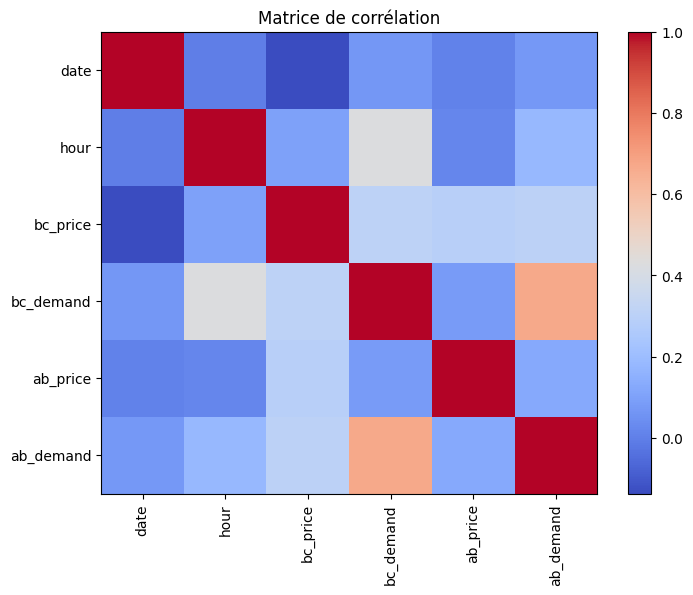

In [147]:
# Calculer la matrice de corrélation
correlation_matrix = data.corr()

# Afficher la matrice de corrélation
print("Matrice de corrélation :")
print(correlation_matrix)

# Afficher la corrélation sous forme de heatmap
plt.figure(figsize=(8, 6))
plt.title('Matrice de corrélation')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()

Essayons de fusionner les variables "date" et "heure" pour obtenir le temps exact 

In [79]:
                      #Colonne heure n'est plus nécessaire ?

Il y'a une corrélation plus ou moins importante entre ab_demand et bc_demand.

Fusionnons ces deux variables en une seule.

In [148]:
data["demand"] = data["ab_demand"] * data["bc_demand"]
data = data.drop(columns=["ab_demand","bc_demand"])

# Construction des modèles

### K Nearest Neighbors

In [ ]:
k_classifier = KNeighborsClassifier(n_neighbors=10 , weights= "distance").fit(data, target)
score = k_classifier.score(data,target)
print(score)

### Gradient Boosting Classifer

In [156]:
gradient_classifier = GradientBoostingClassifier(init=DecisionTreeClassifier(), n_estimators=500, max_depth=200).fit(data, target)
score = gradient_classifier.score(data,target)
print(score)

1.0


In [159]:
scores = cross_validate(
    forest_classifier, data, target, cv=5, n_jobs=2, return_estimator=True
)
cv_test_scores = scores['test_score']
cv_test_scores

array([0.87125282, 0.87818402, 0.88632819, 0.87679778, 0.88372899])

### Support Vector Machines

Dans cette partie, nous allons implémenter un SVM, avec Kernel Linéaire

Malheuresement, un modèle linéaire n'est pas pertinent pour ce modèle. Les données ne peuvent pas etre séparées par une droite

In [34]:
svm_model_linear = SVC(kernel = 'linear').fit(data, target)
accuracy = svm_model_linear.score(data, target)
print("Précision du test:",accuracy)

Précision du test: 0.7238055613341654


### Random Forest

Dans cette partie, nous allons implémenter un random forest (en francais foret aléatoire)

In [151]:
rd = RandomForestClassifier(n_estimators = 500, criterion='entropy') 
forest_classifier =  rd.fit(data, target)
#accuracy = forest_classifier.score(data, target)
#print("Précision du test:",accuracy)

In [101]:
# Obtenir l'importance des variables
feature_importances = clf.feature_importances_

# Afficher l'importance des variables
for i, importance in enumerate(feature_importances):
    print(f"Variable {data.columns[i]} : {importance}")

Variable date : 0.3229225427334159
Variable hour : 0.10437274769959679
Variable bc_price : 0.38943206043257367
Variable ab_price : 0.06255896937487185
Variable demand : 0.12071367975954185


### Bagging Classifier

Dans cette partie, nous allons implémenter un Bagging Classifer

In [ ]:
bagging = BaggingClassifier(estimator=forest_classifier ,n_estimators=4000, max_features=5)
bagging_classifier = bagging.fit(data,target)

In [98]:
#clf = RandomForestClassifier(n_estimators = 300, criterion='entropy',max_features=8,max_depth=200) 
scores = cross_validate(
    clf, data, target, cv=5, n_jobs=2, return_estimator=True
)
cv_test_scores = scores['test_score']
cv_test_scores

array([0.87177266, 0.87766418, 0.88719459, 0.88130307, 0.88563507])

In [ ]:
model_rd_forest =  AdaBoostClassifier(estimator =RandomForestClassifier(n_estimators = 4000, criterion='entropy',max_features=8,max_depth=9),n_estimators=4000)
model_rd_forest.fit(data, target)

### Ada Boost

In [152]:
ada = AdaBoostClassifier(estimator =forest_classifier,n_estimators=4000)
ada_classifier = ada.fit(data,target)

C:\Users\dtchoffonz\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


## Hyper parameter Tuning 

Dans cette partie, nous allons réaliser un tuning des hyper paramètres de notre modèle.

In [ ]:
#Très important KNeighborsClassifier se base sur le calcul des distances,
#donc un prétraitement des variables rend ce modèle plus efficace
model = Pipeline(steps=[
    ("classifier",RandomForestClassifier(n_estimators = 200,criterion = "entropy", max_features=6, max_depth=80)),])

param_grid ={"classifier__n_estimators": [100,200,300],
             "classifier__max_features" : [6,8,10],
             "classifier__max_depth": [80, 90, 100, 110]
             }
#Fin de la partie des hyparamètres

In [ ]:
model_grid_search = GridSearchCV(model, param_grid=param_grid,n_jobs=2, cv=2)#deux(02) validations croisées internes pour déterminer les meilleurs hyparamètres

scores = cross_validate(
    model_grid_search, data, target, cv=10, n_jobs=2, return_estimator=True
)#dix(10) validations croisées externes pour déterminer les performences du modèles

In [ ]:
#Liste des meilleurs hyparamètres pour chaque validation croisée
for cv_fold, estimator_in_fold in enumerate(scores["estimator"]):
    print(
        f"Meilleurs hyperparamètres pour la validation croisée #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

## Evaluation de notre modèle  et création du fichier pour la soummision

In [154]:
def submit(model) :
    data_test = pd.read_csv("test.csv")
    column_id = data_test["id"]
    
    data_test["demand"] = data_test["ab_demand"] * data_test["bc_demand"]
    data_test = data_test.drop(columns=["id","transfer","ab_demand","bc_demand"])
    
    predictions = model.predict(data_test)                                           # Faire des prédictions avec model
    result_df = pd.DataFrame({'id': column_id, 'predictions': predictions})          # Créer un DataFrame avec les colonnes "id" et "predictions"
    result_df.to_csv("predictions.csv", index=False)    

In [155]:

submit(ada_classifier)

#RandomForestClassifier(n_estimators = 300, criterion='entropy',max_features=5,max_depth=200